In [ ]:
import spynnaker8 as p
import pyNN.spiNNaker as sim
import time
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
%matplotlib inline

In [2]:
start_time = time.time()
sim.setup(timestep = 0.1)
TotalDuration = 1000.0
TotalDuration2 = 1000.0
time_resol = 0.1
TimeInt = 1.0 / time_resol
TotalDataPoints = int(TotalDuration * TimeInt)
rate_Poisson_Inp_base = 25
print(TotalDuration)

2021-06-11 17:55:21 INFO: Read cfg files: /home/spinnaker/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg, /home/spinnaker/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg, /home/spinnaker/.spynnaker.cfg
2021-06-11 17:55:21 INFO: Will search these locations for binaries: /home/spinnaker/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/common_model_binaries : /home/spinnaker/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/model_binaries
2021-06-11 17:55:21 WARNING: /home/spinnaker/work/reports has 29 old reports that have not been closed
2021-06-11 17:55:21 WARNING: A timestep was entered that has forced sPyNNaker to automatically slow the simulation down from real time by a factor of 10. To remove this automatic behaviour, please enter a timescaleFactor value in your .spynnaker.cfg
2021-06-11 17:55:21 INFO: Setting time scale factor to 10.
2021-06-11 17:55:21 INFO: Setting machine time step to 100 micro-seconds.


['/home/spinnaker/sPyNNakerGit/SpiNNFrontEndCommon/spinn_front_end_common/interface/spinnaker.cfg', '/home/spinnaker/sPyNNakerGit/sPyNNaker/spynnaker/pyNN/spynnaker.cfg', '/home/spinnaker/.spynnaker.cfg']
1000.0


In [3]:
# Number of Cells in each population
NumCells_exc = 80
NumCells_inh = 20
NumCells_extSource = 80

In [4]:
# Synaptic Connection params
conn_delay = 1.0
conn_weights = 5.0
conn_prob = 0.2

In [5]:
# Excitatory cell params
exc_a_tonic = 0.02
exc_b_tonic = 0.2
exc_c_tonic = -65.0
exc_d_tonic = 6.0
exc_v_init_tonic = -65.0
exc_u_init_tonic = exc_b_tonic * exc_v_init_tonic

In [6]:
# Inhibitory cell params
inh_a_tonic = 0.1
inh_b_tonic = 0.2
inh_c_tonic = -65.0
inh_d_tonic = 6.0
inh_v_init_tonic = -70.0
inh_u_init = inh_b_tonic * inh_v_init_tonic

In [7]:
# Time constants
tau_exc = 1.7
tau_inh = 2.5

In [8]:
# DC bias current
current_Pulse = 0.0

# Setting up the Cell Parameters
exc_cell_params = {
'a': exc_a_tonic, 'b': exc_b_tonic, 
'c': exc_c_tonic, 'd': exc_d_tonic,
#'v_init': exc_v_init_tonic, 'u_init': exc_u_init_tonic,
'tau_syn_E': tau_exc, 'tau_syn_I': tau_inh,
'i_offset': current_Pulse
               }

inh_cell_params = {
    'a' : inh_a_tonic, 'b': inh_b_tonic,
    
    'c': inh_c_tonic, 'd': inh_d_tonic,
    #'v_init' : inh_v_init_tonic,'u_init' : inh_u_init,
    'tau_syn_E' : tau_exc, 'tau_syn_I':tau_inh,
    'i_offset' : current_Pulse
               }

In [9]:
# Defining the populations
external_spike_source_pop = p.Population(NumCells_extSource,p.SpikeSourcePoisson,{'rate': rate_Poisson_Inp_base,'duration': 1000,'start': 100},label='spike_source_poisson')
exc_pop = p.Population(NumCells_exc, p.Izhikevich(**exc_cell_params), label='exc_pop')
inh_pop = p.Population(NumCells_inh, p.Izhikevich(**inh_cell_params), label='inh_pop')

In [10]:
# Defining the Projections between the various populations
#external to excitatory
Proj00 = p.Projection(external_spike_source_pop, exc_pop, p.FixedProbabilityConnector(p_connect=0.5),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

#external to inhibitory
Proj01 = p.Projection(external_spike_source_pop, inh_pop, p.FixedProbabilityConnector(p_connect=0.5),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

#excitatory to inhibitory
Proj02 = p.Projection(exc_pop, inh_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

#inhibitory to excitatory
Proj03 = p.Projection(inh_pop, exc_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='inhibitory')

#inhibitory to inhibitory
Proj04 = p.Projection(inh_pop, inh_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='inhibitory')

#excitatory to excitatory
Proj05 = p.Projection(exc_pop, exc_pop, p.FixedProbabilityConnector(p_connect=conn_prob),p.StaticSynapse(weight=conn_weights, delay=conn_delay), receptor_type='excitatory')

In [11]:
# Record spikes from Ext Source, Spikes AND menbrance voltage from the excitatory and inhibitory populations
external_spike_source_pop.record("spikes") #need to store external spike source records and need to print them
exc_pop.record(("spikes", "v"))
inh_pop.record(("spikes", "v"))
p.run(TotalDuration)
external_spike_source = external_spike_source_pop.spinnaker_get_data("spikes")
exc_spikes = exc_pop.spinnaker_get_data("spikes")
inh_spikes = inh_pop.spinnaker_get_data("spikes")
exc_voltage = exc_pop.spinnaker_get_data("v")
inh_voltage = inh_pop.spinnaker_get_data("v")

2021-06-11 17:55:21 INFO: Starting execution process
2021-06-11 17:55:21 INFO: Simulating for 10000 0.1ms timesteps using a hardware timestep of 10us
2021-06-11 17:55:24 INFO: Time 0:00:03.072168 taken by SpallocMaxMachineGenerator
Pre allocating resources for Extra Monitor support vertices
|0%                          50%                         100%|
2021-06-11 17:55:33 INFO: Time 0:00:08.168084 taken by PreAllocateResourcesForExtraMonitorSupport
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2021-06-11 17:55:37 INFO: Time 0:00:04.763762 taken by PartitionAndPlacePartitioner
Created spalloc job 6011550
2021-06-11 17:55:37 INFO: Created spalloc job 6011550
Waiting for board power commands to complete.
2021-06-11 17:55:37 INFO: Waiting for board power commands to complete.
2021-06-11 17:55:42 INFO: Time 0:00:05.045067 taken by SpallocAllocator
2021-06-11 1

Getting profile data
|0%                          50%                         100%|
2021-06-11 17:56:36 INFO: Time 0:00:00.028896 taken by ProfileDataGatherer
2021-06-11 17:56:36 WARNING: spinnaker_get_data is non-standard PyNN and therefore may not be portable to other simulators. Nor do we guarantee that this function will exist in future releases.
Getting spikes for spike_source_poisson
|0%                          50%                         100%|
Getting spikes for exc_pop
|0%                          50%                         100%|
Getting spikes for inh_pop
|0%                          50%                         100%|
Getting v for exc_pop
|0%                          50%                         100%|
Getting v for inh_pop
|0%                          50%                         100%|


In [12]:
#print(exc_spikes) #print length of source spike data
print(len(exc_spikes))
#print(inh_spikes)
print(len(inh_spikes))
print(len(external_spike_source))
print(inh_spikes)

6850
2595
1779
[[  0.  105.8]
 [  0.  107.2]
 [  0.  108.2]
 ...
 [ 19.  938.5]
 [ 19.  969.5]
 [ 19.  993.1]]


85.625
129.75
22.2375


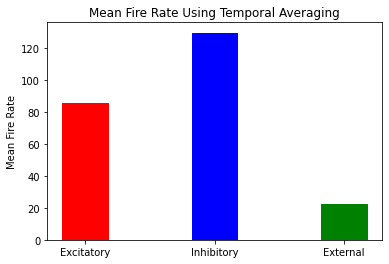

In [28]:
# Mean firing rate using temporal averaging
# Need to calculate mean spike rate for excitatory, inhibitory and external populations
TotalDuration = TotalDuration2/1000.0 # in seconds

# Mean firing rate (per neuron) =        total spikes received
#                                ((total time) * (number of neurons))

mean_firing_exhibitory = len(exc_spikes)/(TotalDuration * NumCells_exc) 
mean_firing_inhibitory = len(inh_spikes)/(TotalDuration * NumCells_inh)
mean_firing_external = len(external_spike_source)/(TotalDuration * NumCells_extSource)

print(mean_firing_exhibitory)
print(mean_firing_inhibitory)
print(mean_firing_external)

x_axis = ['Excitatory','Inhibitory','External']
y_axis = [mean_firing_exhibitory,mean_firing_inhibitory,mean_firing_external]
barlist = plt.bar(x_axis,y_axis,width = 0.35)
barlist[0].set_color('red')
barlist[1].set_color('blue')
barlist[2].set_color('g')
plt.title('Mean Fire Rate Using Temporal Averaging')
plt.ylabel('Mean Fire Rate')
plt.savefig('mean_fire_rate_temporal.png')
plt.show()

[[  0.  106. ]
 [  0.  108. ]
 [  0.  109.1]
 ...
 [ 79.  927.7]
 [ 79.  929.6]
 [ 79.  933.3]]


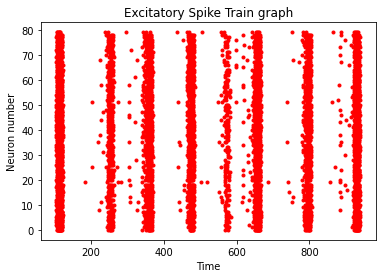

In [34]:
print(exc_spikes)
plt.figure(1)
plt.xlabel('Time')
plt.ylabel('Neuron number')
plt.title('Excitatory Spike Train graph')
plt.savefig('excitatory_raster.png')
plt.plot(exc_spikes[:, 1], exc_spikes[:, 0], '.',color = 'red')
#need to put x and y axis names 
#need to plot graphs for inhibitory and external source

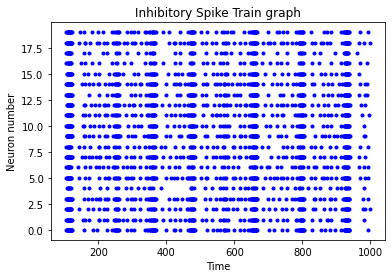

In [35]:
plt.figure(2)
plt.xlabel('Time')
plt.ylabel('Neuron number')
plt.title('Inhibitory Spike Train graph')
plt.savefig('inhibitory_raster.png')
plt.plot(inh_spikes[:, 1], inh_spikes[:, 0], '.',color = 'blue')

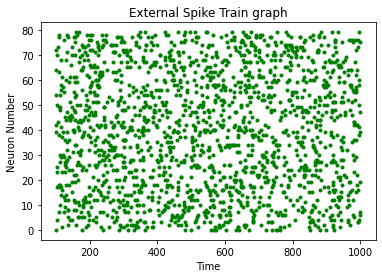

In [31]:
plt.figure(3)
plt.xlabel('Time')
plt.ylabel('Neuron Number')
plt.title('External Spike Train graph')
plt.savefig('external_raster.png')
plt.plot(external_spike_source[:, 1], external_spike_source[:, 0], '.',color = 'green')

[[-70.         -69.99578857 -69.99194336 ... -82.00634766 -81.7565918
  -81.58068848]
 [-70.         -69.99578857 -69.99194336 ... -81.11489868 -81.25680542
  -81.41680908]
 [-70.         -69.99578857 -69.99194336 ... -80.69158936 -80.80700684
  -80.94781494]
 ...
 [-70.         -69.99578857 -69.99194336 ... -86.01583862 -85.82266235
  -85.70141602]
 [-70.         -69.99578857 -69.99194336 ... -78.60137939 -78.81234741
  -79.03103638]
 [-70.         -69.99578857 -69.99194336 ... -69.22497559 -68.89907837
  -68.65338135]]


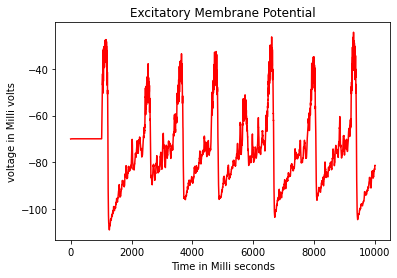

In [32]:
#print(exc_voltage)
#print(len(exc_voltage))
exc_mem_voltage = np.reshape(exc_voltage[:, 2], [NumCells_exc, TotalDataPoints])
print(exc_mem_voltage)
avgsignaltcr = np.mean(exc_mem_voltage, axis=0)
plt.figure(5)
plt.title('Excitatory Membrane Potential')
plt.xlabel('Time in Milli seconds')
plt.ylabel('voltage in Milli volts')
plt.savefig('excitatory_membrance_voltage.png')
plt.plot([x for x in range(TotalDataPoints)], avgsignaltcr,color = 'red')
#plt.plot(exc_mem_voltage[:, 1], exc_mem_voltage[:, 2],)

[[-70.         -69.99578857 -69.99194336 ... -62.48223877 -62.46444702
  -62.48291016]
 [-70.         -69.99578857 -69.99194336 ... -37.87979126 -35.15866089
  -31.82342529]
 [-70.         -69.99578857 -69.99194336 ...   1.487854    23.15933228
  -65.        ]
 ...
 [-70.         -69.99578857 -69.99194336 ... -58.90817261 -59.06085205
  -59.23388672]
 [-70.         -69.99578857 -69.99194336 ... -61.24911499 -60.76702881
  -60.36218262]
 [-70.         -69.99578857 -69.99194336 ... -68.05163574 -67.91656494
  -67.8230896 ]]


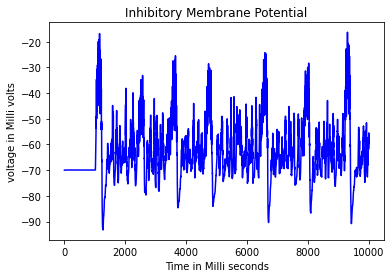

In [33]:
inh_mem_voltage = np.reshape(inh_voltage[:, 2], [NumCells_inh, TotalDataPoints])
print(inh_mem_voltage)
avgsignaltcr1 = np.mean(inh_mem_voltage, axis=0)
plt.figure(6)
plt.title('Inhibitory Membrane Potential')
plt.xlabel('Time in Milli seconds')
plt.ylabel('voltage in Milli volts')
plt.savefig('inhibitory_membrane_voltage.png')
plt.plot([x for x in range(TotalDataPoints)], avgsignaltcr1,color = 'blue')